In [124]:
import glob
from netCDF4 import Dataset
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from kazrRet import *
import lidarSim as lidSim
fs=sorted(glob.glob("CloudSat/anvData/cs*nc"))
iwp1L=[]
iwp2L=[]
# read variable eps from 'simObsInclined_1.0.dm.nc'

tbL=[]
zKuL=[]
iwcL=[]
epsL=[]
dnwL=[]
#import gaussian filter
from scipy.ndimage.filters import gaussian_filter1d
np.random.seed(0)
icount=0

for f in fs[0:]:
    fh=Dataset(f)
    try:
        iwp=fh["iwp"][:]
    except:
        continue
    zw=fh["zw"][:,::-1]
    iwc=fh["iwc"][:,::-1]
    Dm=fh["re"][:,::-1]*3.75e-3
    for i in range(zw.shape[0]):
        a1=np.nonzero(iwc[i,:]>0.01)
        if zw[i].max()>30 or iwc[i].max()<0.05 or len(a1[0])<4 or zw[i,0]>0:
            continue
        zKuL.append(zw[i])
        iwcL.append(iwc[i])
    #print(f)
#plt.plot(iwcL.mean(axis=0),np.arange(40))

import xarray as xr
# save variables tbL,iwcL and zKuL to compressed netcdf file using xarray
ds=xr.Dataset({'iwc':(['time','height'],iwcL),
                 'zKu':(['time','height'],zKuL),},
                coords={'time':np.arange(len(iwcL)),
                        'height':np.arange(50)})

ds.to_netcdf('cloudSat_thr01.nc',format='NETCDF4')

/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_59508/4114944449.py:19: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


ValueError: conflicting sizes for dimension 'height': length 40 on 'height' and length 50 on {'time': 'iwc', 'height': 'iwc'}

In [125]:
ds=xr.Dataset({'iwc':(['time','height'],iwcL),
                 'zKu':(['time','height'],zKuL),},
                coords={'time':np.arange(len(iwcL)),
                        'height':np.arange(50)})

ds.to_netcdf('cloudSat_thr01.nc',format='NETCDF4')

In [ ]:
# add variable label to netcdf file cloudSat_thr01.nc


In [132]:
zKuL=np.array(zKuL)
zKuL[zKuL<-30]=-30
iwcL=np.array(iwcL)
#plt.plot(np.array(zKuL).mean(axis=0),np.arange(40))
# import batch clustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
ns=6
# set plot font size using rcParams
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
nc=ns**2 # number of clusters
kmeans = MiniBatchKMeans(n_clusters=nc, random_state=0).fit(zKuL[:,:-5])
kmeans_iwc=MiniBatchKMeans(n_clusters=nc, random_state=0).fit(iwcL[:,:-5])
import matplotlib.pyplot as plt
nt=zKuL.shape[0]
import netCDF4 as ncf
with ncf.Dataset('cloudSat_thr01.nc','a') as f:
    #f.createDimension('time',nt)
    f.createVariable('zw_label','i4',('time',))
    f.variables['zw_label'][:]=kmeans.labels_
    f.createVariable('iwc_label','i4',('time',))
    f.variables['iwc_label'][:]=kmeans_iwc.labels_
    

[[1.         0.82669644]
 [0.82669644 1.        ]]


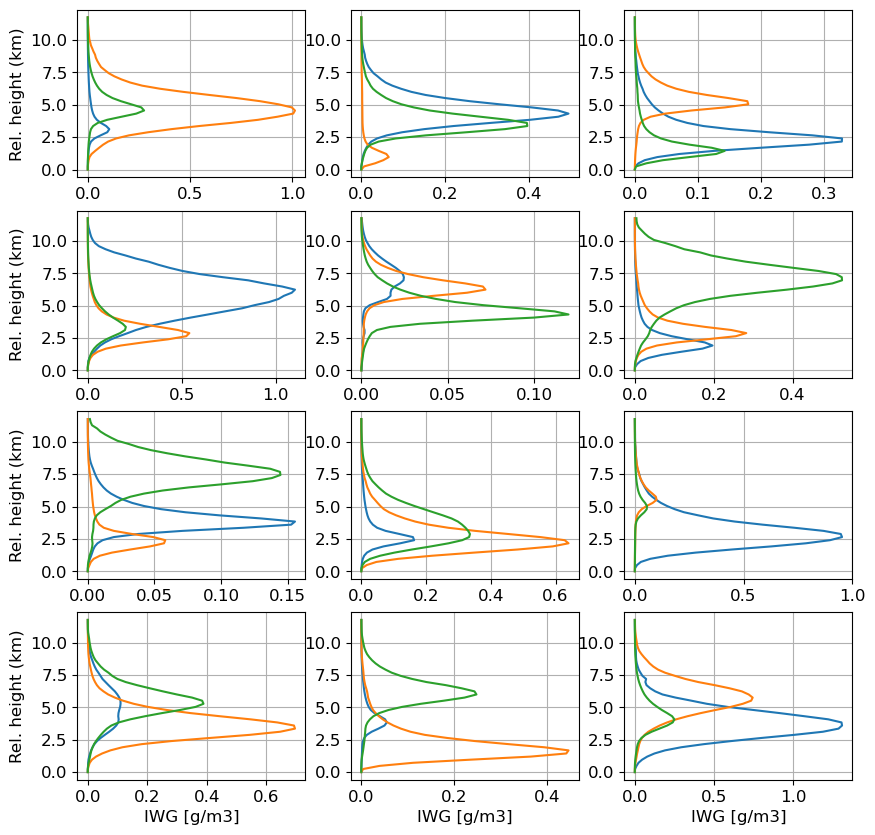

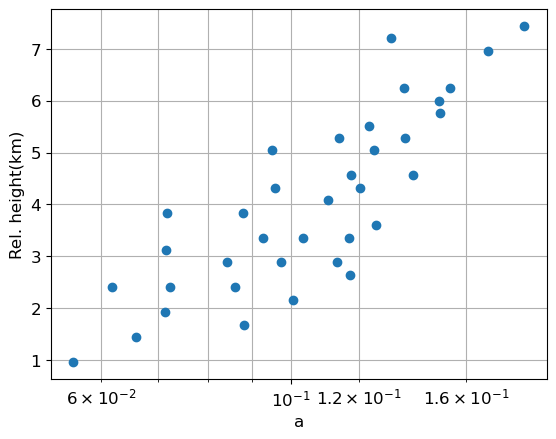

In [129]:
plt.figure(figsize=(10,10))
iwcCoeffL=[]
peakL=[]
iclass=0
for i in range(4):
    for j in range(3):
        ax=plt.subplot(4,3,i*3+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(kmeans_iwc.labels_==iclass)[0]
            if len(a)>0:
                plt.plot(iwcL[a,:].mean(axis=0),np.arange(50)*0.24)
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))

            #plt.xlim(0,0.6)
                b=np.nonzero(iwcL[a,:]>0.001)
                c=np.nonzero(zKuL[a,:][b]>-30)
                iwcm=iwcL[a,:-5].mean(axis=0)
                ind=np.argmax(iwcm)
                ax.grid()
                peakL.append(ind)
                if len(c[0])>0:
                    iwcCoeff=np.polyfit(zKuL[a,:][b][c],np.log10(iwcL[a,:][b][c]),1)
                    iwcRet=10**(iwcCoeff[0]*zKuL[a,:]+iwcCoeff[1])
                #plt.plot(iwcRet.mean(axis=0),range(40))
                    iwcCoeffL.append(iwcCoeff)
            iclass+=1
iwcCoeffL=np.array(iwcCoeffL)
print(np.corrcoef(iwcCoeffL[:,1],peakL))
plt.savefig('iwcClasses.png')
plt.figure()
ax=plt.subplot(111)
plt.semilogx(10**iwcCoeffL[:,1],np.array(peakL)*0.24,'o')
plt.xlabel('a')
plt.ylabel('Rel. height(km)')
plt.grid()
# plot grid for x minor ticks

import matplotlib.ticker as ticker
locator = ticker.FixedLocator([6e-2,7e-2,8e-2,9e-2,1e-1,1.2e-1,1.6e-1,2e-1])
ax.xaxis.set_minor_locator(locator)

plt.grid(which='minor', axis='x')
# specify x minor ticks 
# set scientific style for x axis labels
#ax.ticklabel_format(useMathText=True)
#plt.ticklabel_format(axis='x',style='sci')
#ax.xaxis.major.formatter.
plt.savefig('iwcCoeff.png')

[[1.         0.76917628]
 [0.76917628 1.        ]]


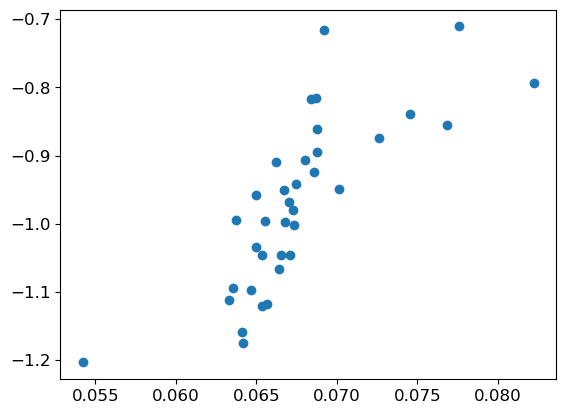

In [123]:
#print(iwcCoeffL)
fh.close()
iwcCoeffL=np.array(iwcCoeffL)
plt.scatter(iwcCoeffL[:,0],iwcCoeffL[:,1])
print(np.corrcoef(iwcCoeffL[:,0],iwcCoeffL[:,1]))

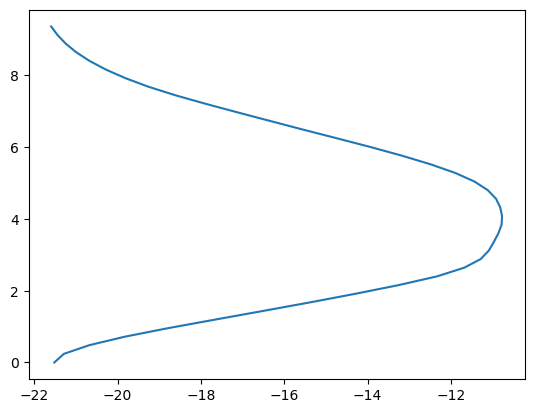

In [61]:
zCFAD=np.zeros((60,40),float)
iwcCFAD=np.zeros((60,40),float)
zwL=[]
for i,zw in enumerate(zKuL):
    if zw[0]>-5:
        continue
    for k in range(40):
        if zw[k]>-22 and zw[k]<30 and iwcL[i,k]>1e-3 and iwcL[i,k]<10:
            zCFAD[int(zw[k]+30),k]+=1
            iwcCFAD[int(15*(3+np.log10(iwcL[i,k]))),k]+=1
    zw[zw<-22]=-22
    zwL.append(zw)
import matplotlib
plt.plot(np.array(zwL).mean(axis=0),np.arange(40)*.24)

134805 137436


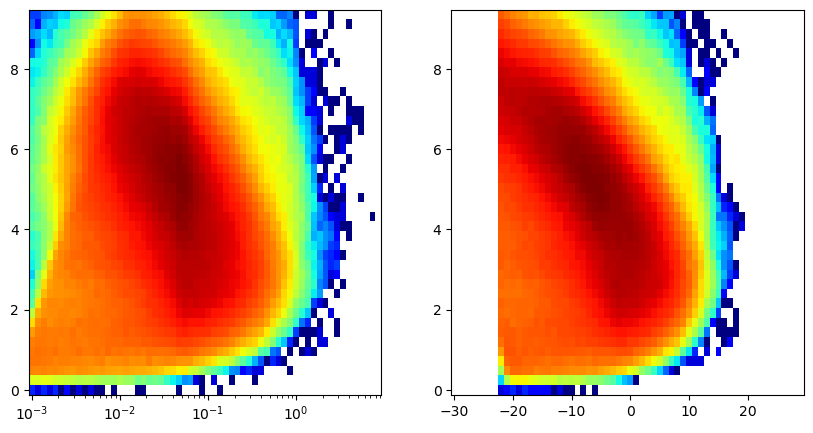

In [62]:
print(len(zwL),len(zKuL))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pcolormesh(10**(np.arange(60)/15-3),np.arange(40)*0.24,iwcCFAD.T,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.xscale('log')
plt.subplot(1,2,2)
plt.pcolormesh(-30+np.arange(60),np.arange(40)*0.24,zCFAD.T,cmap='jet',norm=matplotlib.colors.LogNorm())